**генеративно-состязательные модели (GAN)** 

Евгений Борисов esborisov@sevsu.ru

---

Generative Adversarial Nets  
Ian J. Goodfellow, Yoshua Bengio ....  
2014  

https://arxiv.org/pdf/1406.2661.pdf

Generative adversarial networks  
Max Strakhov 
2018

https://habr.com/ru/post/352794/

Gulli Antonio, Pal Sujit. Deep Learning with Keras -- Packt Publishing, 2017

пара нейросетей генератор (создаёт "подделку") и дискриминатор (распознаёт подделку)

одна эпоха обучения состоит из следующих шагов

1. генератор создаёт пакет "подделок" из случайного шума

2. дискриминатор имеет пакет "настоящих" образцов 
   и обучается распознавать фальшивки на наборе фальшивые/настоящие

3. собираем конвейер генератор-дискриминатор
   фиксируем веса дискриминатора (т.е. дискриминатор в конвейере не обучаем)
   и обучаем генератор "обманывать" дискриминатор

---

In [1]:
import numpy as np
from numpy import random as rng

import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.datasets import mnist
(images, _),(_, _) = mnist.load_data()
images.shape

(60000, 28, 28)

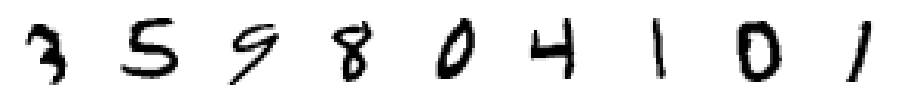

In [4]:
n_show = 9 
plt.figure(figsize=(16,4))
for n,i in enumerate(rng.permutation(len(images))[:n_show], start=1):
    plt.subplot(1,n_show,n)
    plt.axis(False)
    plt.imshow(images[i],cmap='gray_r')

---

In [5]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape

from tensorflow.keras.optimizers import SGD

from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [6]:
# tf.logging.set_verbosity(tf.logging.ERROR)
tf.__version__, tf.keras.__version__

('2.8.0', '2.8.0')

In [2]:
# !mkdir tmp

In [ ]:
# img_rows, img_cols = X_train.shape[1], X_train.shape[2]
# img_rows, img_cols

In [ ]:
# X_train = (X_train - 127.5) / 127.5

In [ ]:
# # X_train = X_train[:,np.newaxis,:,:].astype('float32')
# X_train = X_train[:,:,:,np.newaxis].astype('float32')
# X_train.shape

---

In [ ]:
generator = Sequential(name='generator')
generator.add(Dense(1024, input_shape=(100, ), activation='tanh'))
generator.add(Dense(128 * 7 * 7))
generator.add(BatchNormalization())
generator.add(Activation('tanh'))
generator.add(Reshape((7, 7, 128), input_shape=(7 * 7 * 128,)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64,(5,5),padding='same',activation='tanh',data_format='channels_last'))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1,(5,5),padding='same',activation='tanh',data_format='channels_last'))

In [ ]:
plot_model(generator,to_file='result/model-generator.png', show_layer_names=False, show_shapes=True )
# IPython.display.Image('result/model-generator.png')

----

In [ ]:
discriminator = Sequential(name='discriminator')
discriminator.add(Conv2D(64, (5, 5),
                padding='same',
                input_shape=(28, 28, 1),
                activation='tanh',
                data_format='channels_last'
   ))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Conv2D(128,(5,5),activation='tanh',data_format='channels_last'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Flatten())
discriminator.add(Dense(1024, activation='tanh'))
discriminator.add(Dense(1, activation='sigmoid'))

In [ ]:
plot_model(discriminator,to_file='result/model-discriminator.png',show_layer_names=False, show_shapes=True )
# IPython.display.Image('result/model-discriminator.png')

---

In [ ]:
discriminator_on_generator = Sequential()
discriminator_on_generator.add(generator)
discriminator.trainable = False
discriminator_on_generator.add(discriminator)

plot_model( discriminator_on_generator, 
            to_file='result/model-discriminator_on_generator.png', 
            show_shapes=True, 
            show_layer_names=True )

# IPython.display.Image('result/model-discriminator_on_generator.png')

---

In [ ]:
generator.compile(loss='binary_crossentropy', optimizer="SGD")

discriminator_on_generator.compile(
    loss='binary_crossentropy', 
    optimizer=SGD(learning_rate=0.0005, momentum=0.9, nesterov=True)
  )

discriminator.trainable = True
discriminator.compile(
    loss='binary_crossentropy', 
    optimizer=SGD(learning_rate=0.0005, momentum=0.9, nesterov=True)
  )


---

In [ ]:
from PIL import Image

def save_images(X,e,b,mc=10):
    # mc = 14 # количество картинок в одной строке 
    n,r,c,m = X.shape # примеры, высота, ширина, каналы
    mr = int(np.ceil(n/mc)) # количество строк 
    
    # print(n,c,r,m)
    
    im = []
    for k in range(m):
        xk = X[:,:,:,k] # канал k
        # дополняем строку до полного размера пустыми картинками
        xk = np.vstack([xk,-np.ones([(mc*mr-n),r,c])]) 
        # укладываем картинки, [mr x mc] картинок размера [r x c]
        xk = xk.reshape(mr,mc,r,c).swapaxes(1,2).reshape(mr*r,mc*c) 
        im.append(xk*127.5+127.5) # масштабируем в [0,255]

    im = np.stack(im,axis=2) if m>1 else im[0]
   
    Image.fromarray(im.astype(np.uint8)).save('result/%02d_%d.png'%(e,b) )


In [ ]:
# xx = np.random.rand(128,100,3)*255.
# Image.fromarray(xx.astype(np.uint8)).save('result/test.png')

---

In [ ]:
BATCH_SIZE = 250
N_EPOCH = 50

N_EX = X_train.shape[0]
N_BATCH = int( np.floor(N_EX/BATCH_SIZE) )

mc=int(np.ceil(np.sqrt(BATCH_SIZE))) 

N_EX, N_BATCH

In [ ]:
def chunks(X, batch_size=BATCH_SIZE): 
    for i in range(0, len(X), batch_size): 
        yield X[i:i+batch_size]

In [ ]:
%%time

for e in range(N_EPOCH):
    print('epoch: ', e+1,'/',N_EPOCH)
    
    for b,Xb in enumerate(chunks(X_train)):
        print('\tbatch %d/%d, loss '%(b+1,N_BATCH))

        # генератор создаёт пакет "подделок" из случайного шума
        noise = np.random.uniform(-1, 1, (BATCH_SIZE,100))
        Xg = generator.predict(noise, verbose=0)
        
        # рисуем результат после каждого 200-го батча
        if b % 200 == 0: save_images(Xg,e,b,mc=mc)
        
        # собираем учебный набор для дискриминатора
        # из "фальшивых" и "настоящик" картинок
        X = np.concatenate((Xb, Xg))
        y = [1] * Xb.shape[0] + [0] * Xg.shape[0]

        # обучаем дискриминатор выявлять "фальшивые"
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y)
        print('\t\t%f : discriminator'%(d_loss))
        
        # обучаем генератор "обманывать" дискриминатор
        noise = np.random.uniform(-1,1,(BATCH_SIZE,100))
        discriminator.trainable = False
        g_loss = discriminator_on_generator.train_on_batch( noise, [1]*BATCH_SIZE)
        
        print('\t\t%f : generator'%(g_loss))


In [ ]:
# generator.save_weights('result/generator', True)
# discriminator.save_weights('result/discriminator', True)

In [ ]:
#  730 - 3h 25min 26s
# 1060 -    18min 24s

In [ ]:
# ((60*3+25)*60+26)/ ((18)*60+24)

---

In [ ]:
# начальное состояние
IPython.display.Image('result/00_0.png')

In [ ]:
# после 1 эпохи обучения
IPython.display.Image('result/02_0.png')

In [ ]:
# после 9 эпохи обучения
IPython.display.Image('result/09_0.png')

In [ ]:
# конечный результат (50 эпох обучения)
IPython.display.Image('result/49_200.png')